In [1]:
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 98.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import joblib

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, classification_report, auc
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegressionCV, LassoCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Concatenate, Attention, Conv1D, MaxPooling1D, Flatten, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikeras
from scikeras.wrappers import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

2025-05-09 06:32:39.973030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746772360.169023      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746772360.222353      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preprocessing

In [3]:
def load_data(phase):
    # Đọc dữ liệu từ các file CSV
    phase_ = phase[:-1] + '_' + phase[-1]
    X_train = pd.read_csv(f"/kaggle/input/final-data/{phase}/user_train_{phase_}_train.csv")
    X_test = pd.read_csv(f"/kaggle/input/final-data/{phase}/user_train_{phase_}_test.csv")
    
    # In thông tin chung về dữ liệu
    print(X_train.info())

    # Mã hóa cột 'school' bằng số lượng xuất hiện
    count_map = X_train['school'].value_counts().to_dict()
    X_train['school'] = X_train['school'].map(count_map)
    X_test['school'] = X_test['school'].map(count_map)

    # Fill nan = 0
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    
    # Loại bỏ các cột không cần thiết
    columns_to_drop = ['course_id', 'user_id', 'total_score', 'type', 'label']
    X_train = X_train.drop(columns=columns_to_drop, axis=1)
    X_test = X_test.drop(columns=columns_to_drop, axis=1)
    
    # Lấy target
    y_train = X_train.pop("label_encoded")
    y_test = X_test.pop("label_encoded")
    
    # Encode label → categorical
    label_encoder = LabelEncoder()
    y_encoded_train = label_encoder.fit_transform(y_train)
    y_categorical_train = to_categorical(y_encoded_train, num_classes=5)

    y_encoded_test = label_encoder.transform(y_test)
    y_categorical_test = to_categorical(y_encoded_test, num_classes=5)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape cho CNN 1D (samples, timesteps, features = 1)
    X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
    X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
    num_features = X_train_scaled.shape[1]

    return X_train_cnn, y_categorical_train, y_encoded_train, X_test_cnn, y_categorical_test, y_encoded_test, num_features

# Evaluate Model

In [4]:
def evaluate_model(model, X, y_encoded, y_categorical, split_name, class_names=["E", "D", "C", "B", "A"]):
    # Dự đoán xác suất
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_bin = label_binarize(y_encoded, classes=np.arange(len(class_names)))

    # Tính các metric
    f1 = f1_score(y_encoded, y_pred, average=None)
    precision = precision_score(y_encoded, y_pred, average=None)
    recall = recall_score(y_encoded, y_pred, average=None)
    accuracy = accuracy_score(y_encoded, y_pred)
    try:
        roc_auc = roc_auc_score(y_bin, y_pred_probs, multi_class="ovr")
    except ValueError:
        roc_auc = np.nan

    # In kết quả metrics
    print(f"\n--- {split_name} Metrics ---")
    print("F1 (per class):", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC (OvR): {roc_auc:.4f}")
    print(classification_report(y_encoded, y_pred, target_names=class_names))

    # Vẽ Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_encoded, y_pred), annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{split_name} Confusion Matrix")
    plt.show()

    # ROC Curve
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_pred_probs[:, i])
        auc_score = roc_auc_score(y_bin[:, i], y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve - {split_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

# Building Model

In [5]:
def create_model(learning_rate=0.001, dropout_rate=0.5, num_filters=64, input_shape_cnn=None):
    model = Sequential([
        Conv1D(num_filters, 3, activation='relu', padding='same', input_shape=input_shape_cnn),
        MaxPooling1D(2),
        Dropout(dropout_rate),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(dropout_rate),
        Dense(5, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def tune_hyperparameters(X, y):
    model = KerasClassifier(build_fn=create_model, verbose=0)
    param_dist = {
        'batch_size': [16, 32, 64],
        'epochs': [20, 50],
        'learning_rate': [0.001, 0.0005],
        'dropout_rate': [0.3, 0.5],
        'num_filters': [32, 64, 128]
    }
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                       n_iter=10, cv=3, verbose=2, n_jobs=-1)
    random_search.fit(X, y)
    print("Best hyperparameters:", random_search.best_params_)

# Feature Importances

In [6]:
def get_permutation_importance(model, X_train, y_train, feature_names):
    result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": result.importances_mean
    }).sort_values(by="Importance", ascending=False)
    return importance_df

def get_lasso_feature_importance(X_train, y_train, feature_names):
    from sklearn.linear_model import LassoCV

    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1)
    lasso.fit(X_train, y_train)
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(lasso.coef_)
    }).sort_values(by='Importance', ascending=False)
    
    return importance_df

def combine_feature_importances(perm_df, lasso_df, top_k=20):
    perm_top = perm_df.head(top_k)['Feature']
    lasso_top = lasso_df.head(top_k)['Feature']
    
    all_features = pd.concat([perm_top, lasso_top])
    feature_counts = all_features.value_counts().reset_index()
    feature_counts.columns = ['Feature', 'Count']
    
    feature_counts = feature_counts.sort_values(by='Count', ascending=False)
    
    print("\n=== Combined Top Features ===")
    for idx, row in feature_counts.iterrows():
        print(f"{row['Feature']}: xuất hiện {row['Count']} lần")
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Feature', data=feature_counts, palette='viridis')
    plt.title(f"Combined Top Features (Top {top_k} mỗi phương pháp)")
    plt.xlabel("Số lần xuất hiện trong top")
    plt.ylabel("Tên feature")
    plt.show()
    
    return feature_counts

# Training Model

In [7]:
def process_phase(phase, metric='f1_macro'):
    X_train_cnn, y_categorical_train, y_encoded_train, X_test_cnn, y_categorical_test, y_encoded_test, num_features = load_data(phase)
    
    feature_names = [f"feature_{i}" for i in range(X_train_cnn.shape[1])]

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
    ]

    batch_sizes = [32, 64]
    learning_rates = [0.0005, 0.001]
    best_score = -np.inf
    best_params = {}

    for bs in batch_sizes:
        for lr in learning_rates:
            cv_scores = []
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            for train_idx, val_idx in skf.split(X_train_cnn, y_encoded_train):
                model = create_model(learning_rate=lr)
                model.fit(X_train_cnn[train_idx], y_categorical_train[train_idx],
                          epochs=50, batch_size=bs,
                          validation_data=(X_train_cnn[val_idx], y_categorical_train[val_idx]),
                          callbacks=callbacks, verbose=0)
                val_loss, val_acc = model.evaluate(X_train_cnn[val_idx], y_categorical_train[val_idx], verbose=0)
                cv_scores.append(val_acc)
            mean_acc = np.mean(cv_scores)
            print(f"Batch {bs}, LR {lr}, Mean Accuracy: {mean_acc:.4f}")
            if mean_acc > best_score:
                best_score = mean_acc
                best_params = {'batch_size': bs, 'learning_rate': lr}

    print(f"Best params: {best_params}, Best Accuracy: {best_score:.4f}")

    final_model = create_model(learning_rate=best_params['learning_rate'])
    final_model.fit(X_train_cnn, y_categorical_train,
                    epochs=100, batch_size=best_params['batch_size'],
                    validation_split=0.2,
                    callbacks=callbacks, verbose=1)

    print(f"\n=== Evaluation for phase {phase} ===")
    print("\n[Train Evaluation]")
    evaluate_model(final_model, X_train_cnn, y_encoded_train, y_categorical_train, "Train")
    print("\n[Test Evaluation]")
    evaluate_model(final_model, X_test_cnn, y_encoded_test, y_categorical_test, "Test")

    # Feature Importance with Permutation
    print("\n[Feature Importance with Permutation]")
    X_train_flat = X_train_cnn.reshape(X_train_cnn.shape[0], -1)
    X_test_flat = X_test_cnn.reshape(X_test_cnn.shape[0], -1)
    lr_clf = LogisticRegressionCV(cv=5, multi_class='multinomial', max_iter=500).fit(X_train_flat, y_encoded_train)
    result = permutation_importance(lr_clf, X_test_flat, y_encoded_test, n_repeats=10, random_state=42)
    sorted_idx = result.importances_mean.argsort()[::-1]
    for idx in sorted_idx[:10]:
        print(f"{feature_names[idx]}: Mean importance {result.importances_mean[idx]:.4f}")

    # Feature Importance with Lasso
    print("\n[Feature Importance with Lasso]")
    lasso = LassoCV(cv=5, random_state=42).fit(X_train_flat, y_encoded_train)
    importance = np.abs(lasso.coef_)
    top_idx = np.argsort(importance)[::-1][:10]
    for idx in top_idx:
        print(f"{feature_names[idx]}: Lasso weight {lasso.coef_[idx]:.4f}")

    print("\n[Combined Feature Importance]")
    perm_df = get_permutation_importance(lr_clf, X_train_flat, y_encoded_train, feature_names)
    lasso_df = get_lasso_feature_importance(X_train_flat, y_encoded_train, feature_names)
    combined_df = combine_feature_importances(perm_df, lasso_df)
    
    print(f"\n=== Phase {phase} completed ===")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 70 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   user_id                              10570 non-null  object 
 1   school                               6715 non-null   object 
 2   course_id                            10570 non-null  object 
 3   field_encoded_1                      10570 non-null  int64  
 4   field_encoded_2                      10570 non-null  int64  
 5   start_year                           10570 non-null  float64
 6   start_month                          10570 non-null  float64
 7   end_year                             10570 non-null  float64
 8   end_month                            10570 non-null  float64
 9   user_year                            10570 non-null  float64
 10  user_month                           10570 non-null  float64
 11  video_count                 

I0000 00:00:1746772371.316487      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1746772373.292056      67 service.cc:148] XLA service 0x7b9c0000b5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746772373.292566      67 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746772373.646510      67 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746772376.002475      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Batch 32, LR 0.0005, Mean Accuracy: 0.7012
Batch 32, LR 0.001, Mean Accuracy: 0.7033
Batch 64, LR 0.0005, Mean Accuracy: 0.6936
Batch 64, LR 0.001, Mean Accuracy: 0.6957
Best params: {'batch_size': 32, 'learning_rate': 0.001}, Best Accuracy: 0.7033
Epoch 1/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6705 - loss: 0.8479 - val_accuracy: 0.6235 - val_loss: 0.8303 - learning_rate: 0.0010
Epoch 2/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6991 - loss: 0.7314 - val_accuracy: 0.6476 - val_loss: 0.7919 - learning_rate: 0.0010
Epoch 3/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7135 - loss: 0.6943 - val_accuracy: 0.6074 - val_loss: 0.7848 - learning_rate: 0.0010
Epoch 4/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7126 - loss: 0.6985 - val_accuracy: 0.6112 - val_loss: 0.7807 - learning_rate: 0.0010
Epoch 5/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7118 - loss: 0.6936 - val_accuracy: 0.6178 - val_loss: 0.7866 - learning

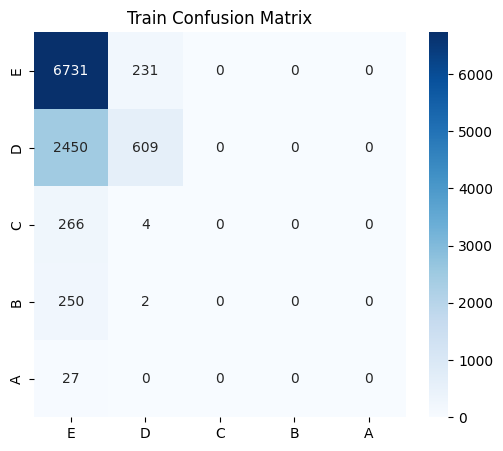

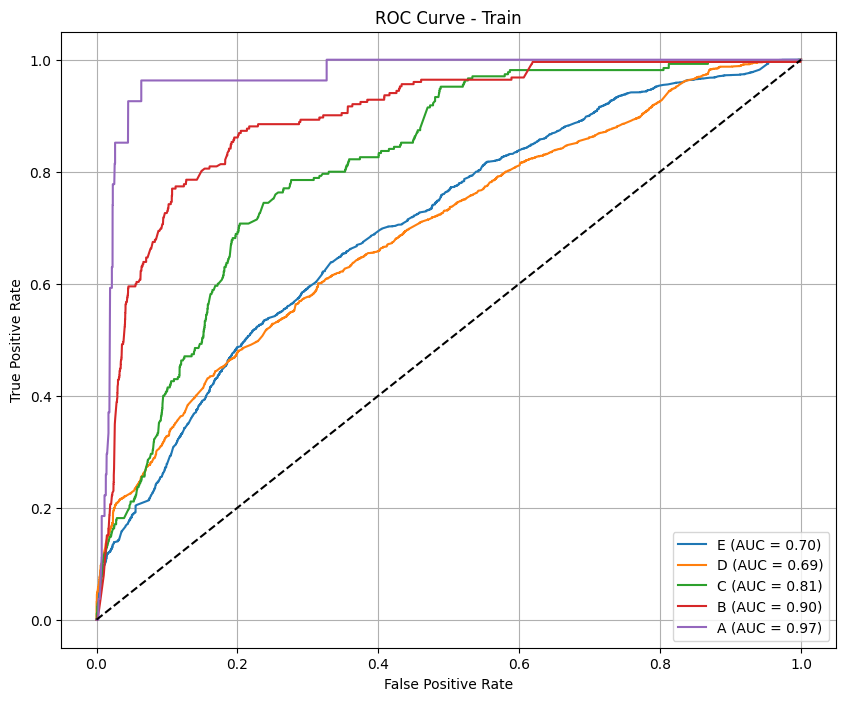


[Test Evaluation]
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

--- Test Metrics ---
F1 (per class): [0.90371494 0.19047619 0.         0.         0.        ]
Precision: [0.84779516 0.26415094 0.         0.         0.        ]
Recall: [0.96753247 0.14893617 0.         0.         0.        ]
Accuracy: 0.8069
ROC AUC (OvR): 0.5928
              precision    recall  f1-score   support

           E       0.85      0.97      0.90       616
           D       0.26      0.15      0.19        94
           C       0.00      0.00      0.00        20
           B       0.00      0.00      0.00        16
           A       0.00      0.00      0.00        10

    accuracy                           0.81       756
   macro avg       0.22      0.22      0.22       756
weighted avg       0.72      0.81      0.76       756



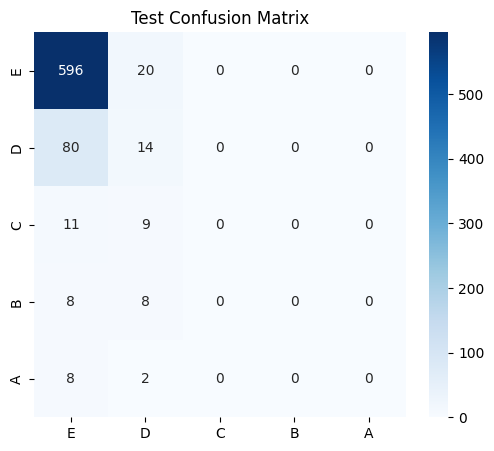

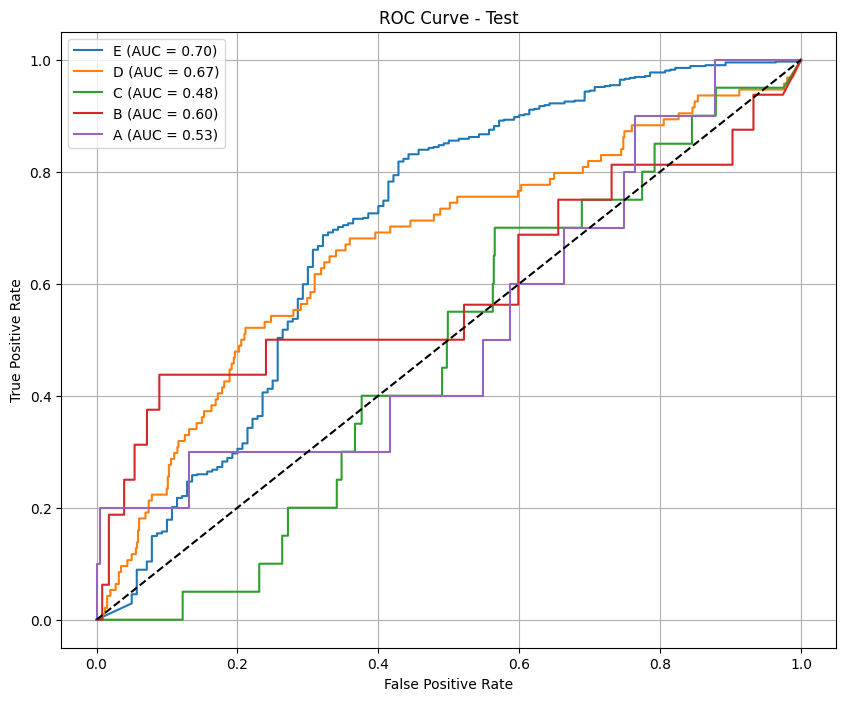


[Feature Importance with Permutation]
feature_44: Mean importance 0.0757
feature_24: Mean importance 0.0501
feature_23: Mean importance 0.0485
feature_42: Mean importance 0.0317
feature_46: Mean importance 0.0155
feature_15: Mean importance 0.0139
feature_20: Mean importance 0.0077
feature_43: Mean importance 0.0058
feature_36: Mean importance 0.0049
feature_22: Mean importance 0.0046

[Feature Importance with Lasso]
feature_4: Lasso weight 0.2982
feature_3: Lasso weight 0.2658
feature_11: Lasso weight -0.1517
feature_9: Lasso weight 0.1455
feature_17: Lasso weight -0.1411
feature_19: Lasso weight -0.1025
feature_16: Lasso weight 0.0882
feature_44: Lasso weight 0.0851
feature_10: Lasso weight -0.0816
feature_23: Lasso weight 0.0797

[Combined Feature Importance]

=== Combined Top Features ===
feature_4: xuất hiện 2 lần
feature_3: xuất hiện 2 lần
feature_42: xuất hiện 2 lần
feature_44: xuất hiện 2 lần
feature_23: xuất hiện 2 lần
feature_28: xuất hiện 2 lần
feature_11: xuất hiện 2 lần
f

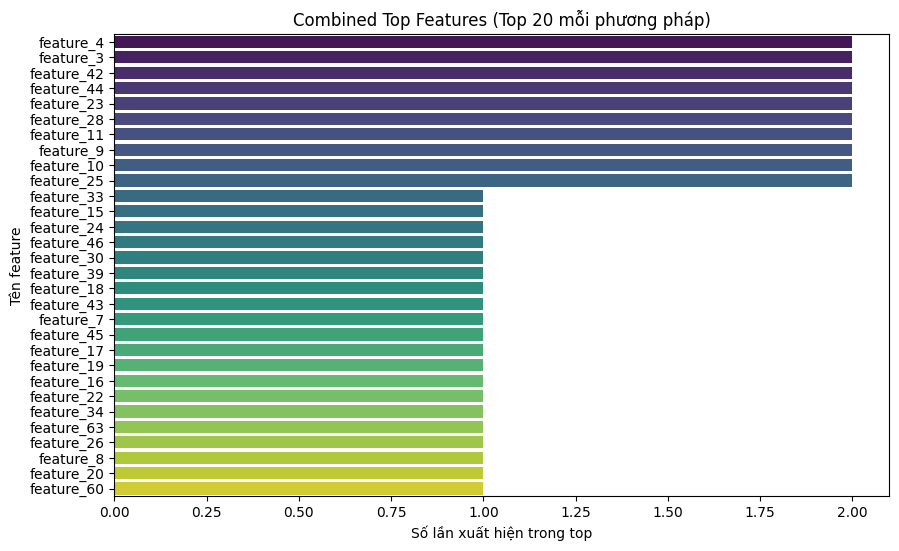


=== Phase phase1 completed ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8548 entries, 0 to 8547
Columns: 113 entries, user_id to label_encoded
dtypes: float64(100), int64(9), object(4)
memory usage: 7.4+ MB
None
Batch 32, LR 0.0005, Mean Accuracy: 0.6809
Batch 32, LR 0.001, Mean Accuracy: 0.6820
Batch 64, LR 0.0005, Mean Accuracy: 0.6812
Batch 64, LR 0.001, Mean Accuracy: 0.6862
Best params: {'batch_size': 64, 'learning_rate': 0.001}, Best Accuracy: 0.6862
Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6541 - loss: 0.9364 - val_accuracy: 0.5760 - val_loss: 0.8076 - learning_rate: 0.0010
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6836 - loss: 0.7839 - val_accuracy: 0.6047 - val_loss: 0.8122 - learning_rate: 0.0010
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6996 - loss: 0.7275 - val_accuracy: 0.6520 - val_loss: 0.7826 - learning_rate: 0.0010
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.68

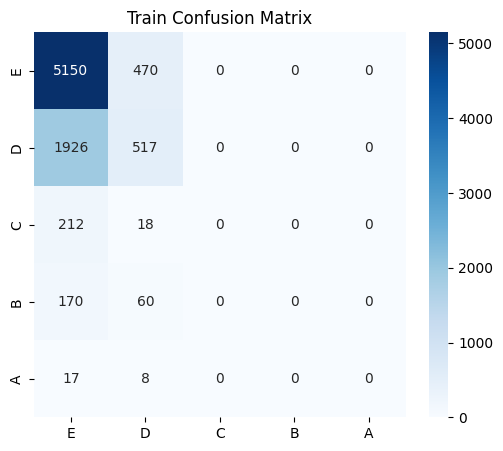

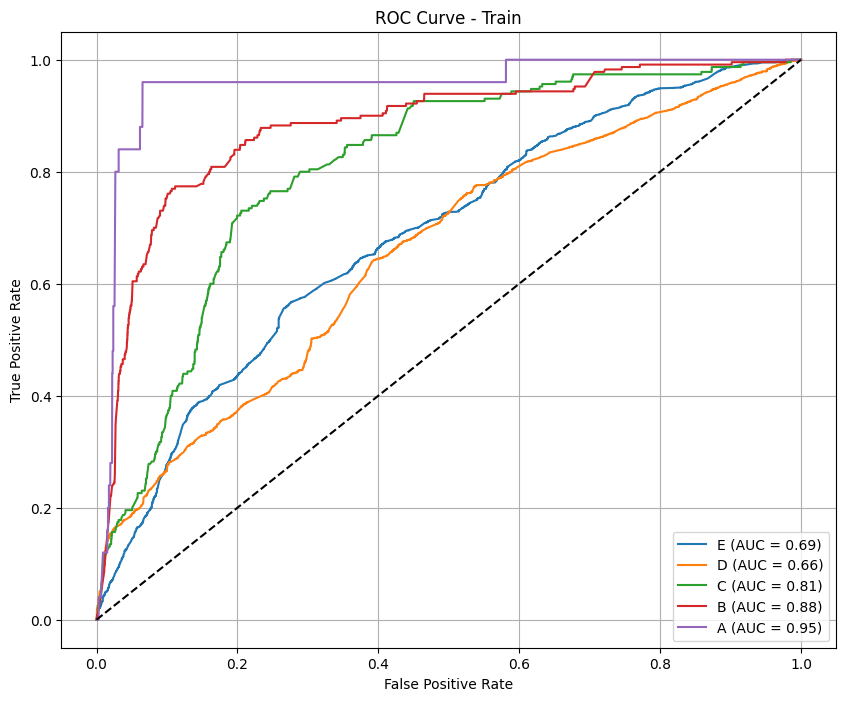


[Test Evaluation]
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

--- Test Metrics ---
F1 (per class): [0.89962264 0.16393443 0.         0.         0.        ]
Precision: [0.83240223 0.33333333 0.         0.         0.        ]
Recall: [0.97865353 0.10869565 0.         0.         0.        ]
Accuracy: 0.8123
ROC AUC (OvR): 0.4733
              precision    recall  f1-score   support

           E       0.83      0.98      0.90       609
           D       0.33      0.11      0.16        92
           C       0.00      0.00      0.00        20
           B       0.00      0.00      0.00        15
           A       0.00      0.00      0.00        10

    accuracy                           0.81       746
   macro avg       0.23      0.22      0.21       746
weighted avg       0.72      0.81      0.75       746



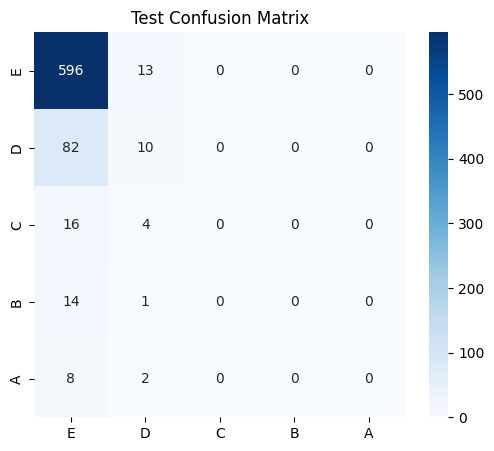

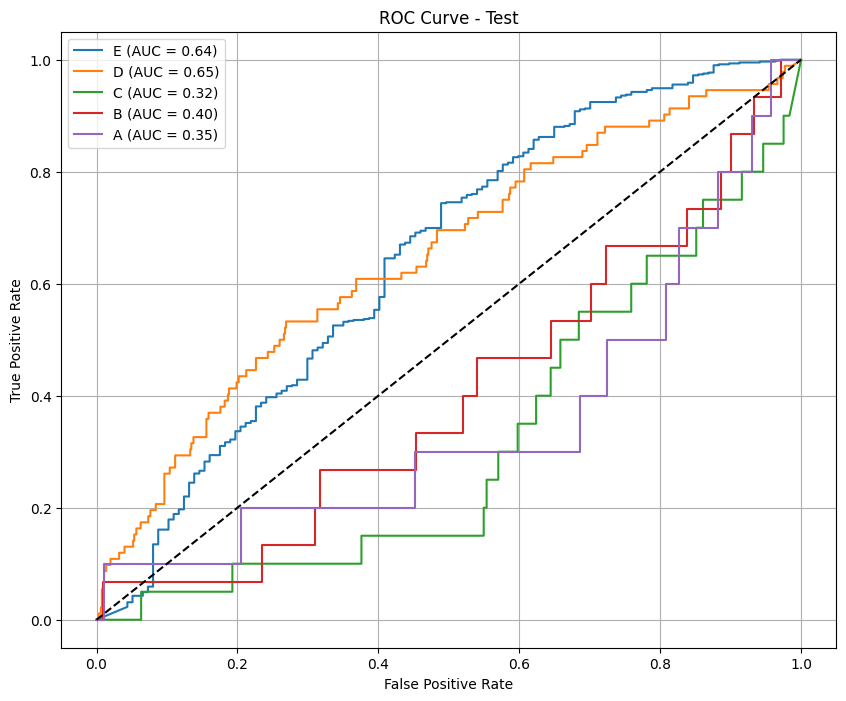


[Feature Importance with Permutation]
feature_44: Mean importance 0.0170
feature_23: Mean importance 0.0142
feature_87: Mean importance 0.0062
feature_32: Mean importance 0.0031
feature_10: Mean importance 0.0027
feature_11: Mean importance 0.0024
feature_13: Mean importance 0.0024
feature_24: Mean importance 0.0021
feature_66: Mean importance 0.0020
feature_45: Mean importance 0.0015

[Feature Importance with Lasso]
feature_17: Lasso weight -0.1351
feature_11: Lasso weight -0.1310
feature_19: Lasso weight -0.1217
feature_9: Lasso weight 0.1059
feature_16: Lasso weight 0.0912
feature_10: Lasso weight -0.0873
feature_66: Lasso weight 0.0648
feature_4: Lasso weight 0.0645
feature_20: Lasso weight 0.0399
feature_106: Lasso weight -0.0373

[Combined Feature Importance]

=== Combined Top Features ===
feature_66: xuất hiện 2 lần
feature_15: xuất hiện 2 lần
feature_23: xuất hiện 2 lần
feature_10: xuất hiện 2 lần
feature_11: xuất hiện 2 lần
feature_87: xuất hiện 1 lần
feature_68: xuất hiện 1 

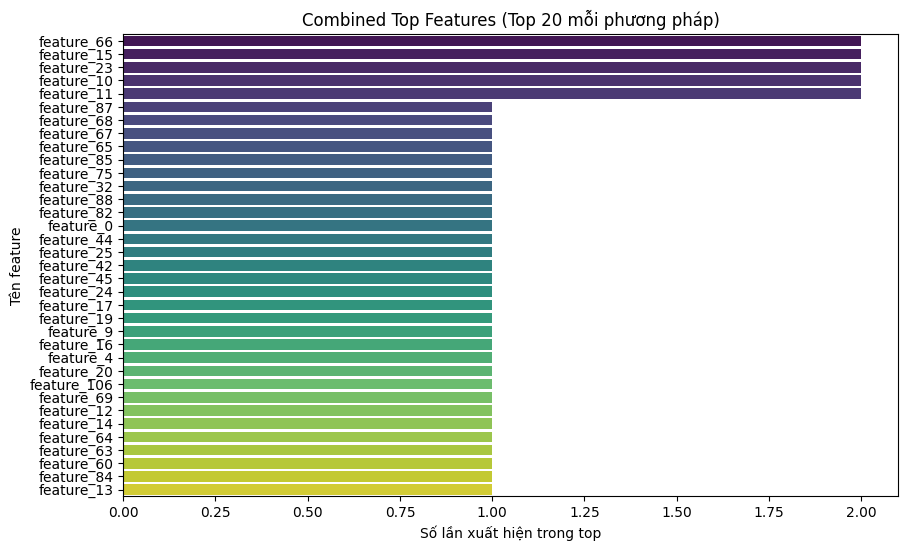


=== Phase phase2 completed ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7803 entries, 0 to 7802
Columns: 156 entries, user_id to label_encoded
dtypes: float64(143), int64(9), object(4)
memory usage: 9.3+ MB
None
Batch 32, LR 0.0005, Mean Accuracy: 0.6904
Batch 32, LR 0.001, Mean Accuracy: 0.6779
Batch 64, LR 0.0005, Mean Accuracy: 0.6814
Batch 64, LR 0.001, Mean Accuracy: 0.6823
Best params: {'batch_size': 32, 'learning_rate': 0.0005}, Best Accuracy: 0.6904
Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6473 - loss: 0.9417 - val_accuracy: 0.6163 - val_loss: 0.8219 - learning_rate: 5.0000e-04
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6809 - loss: 0.7873 - val_accuracy: 0.5657 - val_loss: 0.8140 - learning_rate: 5.0000e-04
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6856 - loss: 0.7421 - val_accuracy: 0.5804 - val_loss: 0.7974 - learning_rate: 5.0000e-04
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - a

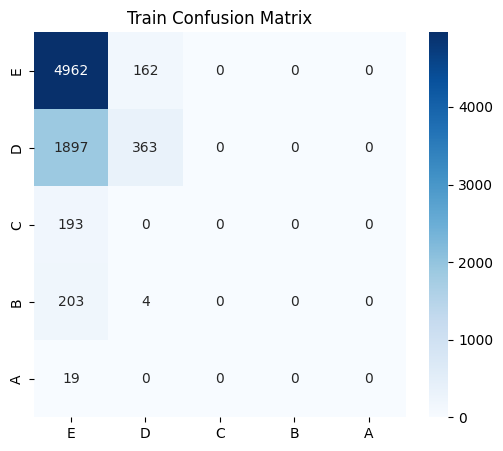

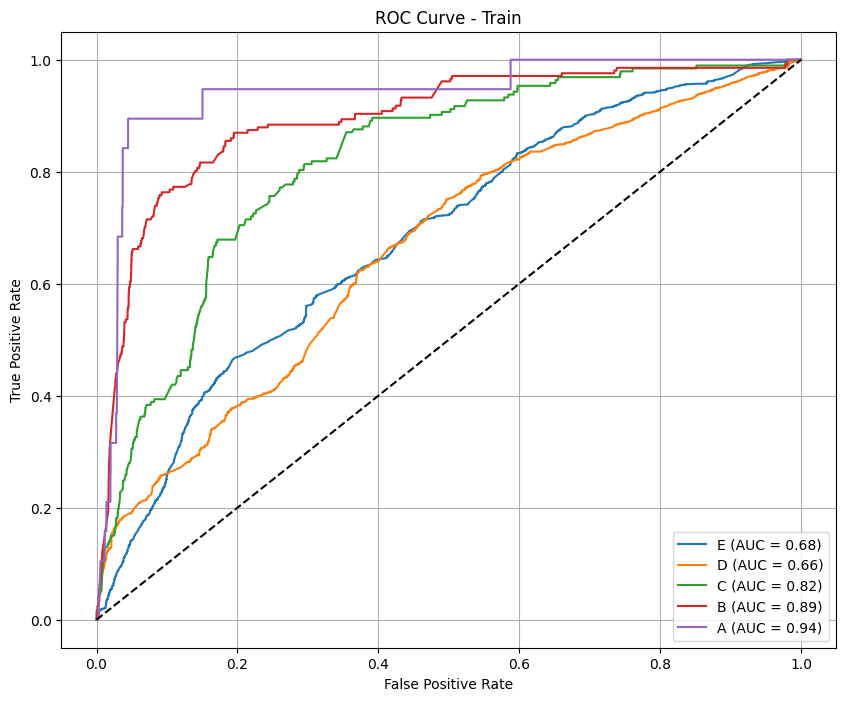


[Test Evaluation]
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

--- Test Metrics ---
F1 (per class): [0.8911353  0.05454545 0.         0.         0.        ]
Precision: [0.82091691 0.13043478 0.         0.         0.        ]
Recall: [0.9744898  0.03448276 0.         0.         0.        ]
Accuracy: 0.7989
ROC AUC (OvR): 0.3289
              precision    recall  f1-score   support

           E       0.82      0.97      0.89       588
           D       0.13      0.03      0.05        87
           C       0.00      0.00      0.00        20
           B       0.00      0.00      0.00        16
           A       0.00      0.00      0.00        10

    accuracy                           0.80       721
   macro avg       0.19      0.20      0.19       721
weighted avg       0.69      0.80      0.73       721



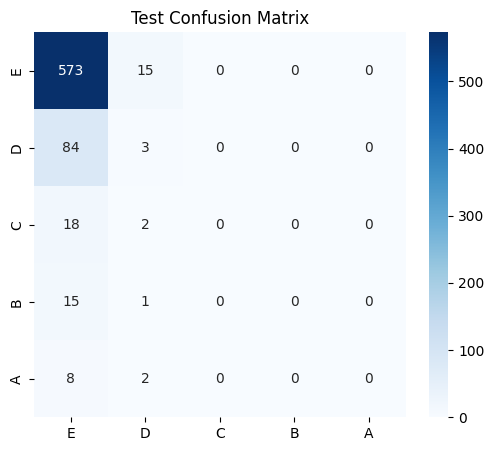

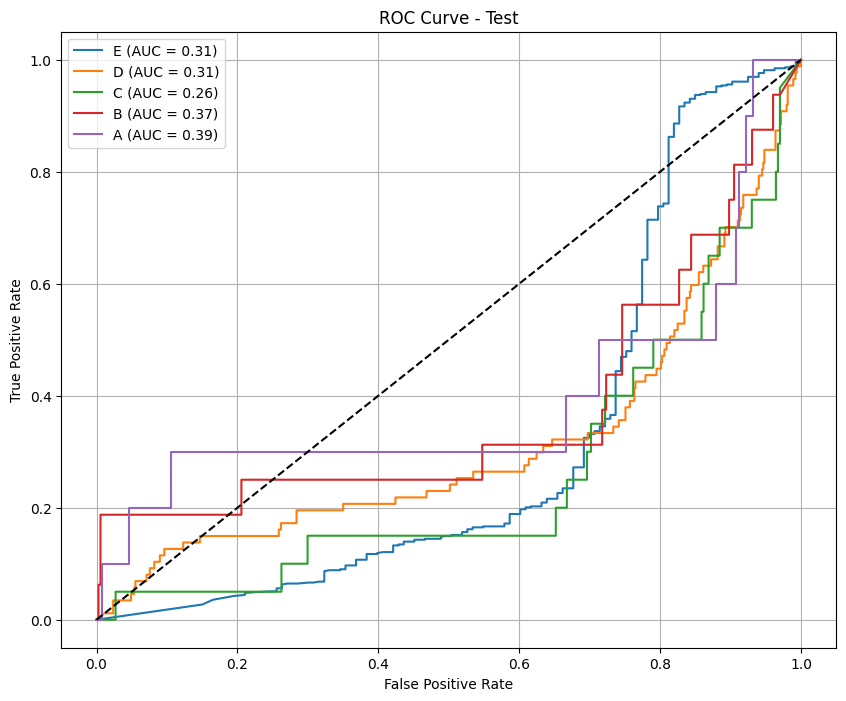


[Feature Importance with Permutation]
feature_122: Mean importance 0.0017
feature_124: Mean importance 0.0015
feature_80: Mean importance 0.0015
feature_34: Mean importance 0.0012
feature_99: Mean importance 0.0011
feature_87: Mean importance 0.0007
feature_14: Mean importance 0.0006
feature_65: Mean importance 0.0006
feature_12: Mean importance 0.0006
feature_130: Mean importance 0.0004

[Feature Importance with Lasso]
feature_3: Lasso weight 0.8590
feature_4: Lasso weight 0.7959
feature_6: Lasso weight -0.1644
feature_9: Lasso weight 0.1542
feature_17: Lasso weight -0.1497
feature_11: Lasso weight -0.1488
feature_109: Lasso weight 0.1353
feature_16: Lasso weight 0.1026
feature_111: Lasso weight -0.0946
feature_66: Lasso weight 0.0936

[Combined Feature Importance]

=== Combined Top Features ===
feature_68: xuất hiện 2 lần
feature_66: xuất hiện 2 lần
feature_10: xuất hiện 2 lần
feature_130: xuất hiện 2 lần
feature_111: xuất hiện 2 lần
feature_109: xuất hiện 2 lần
feature_87: xuất hiệ

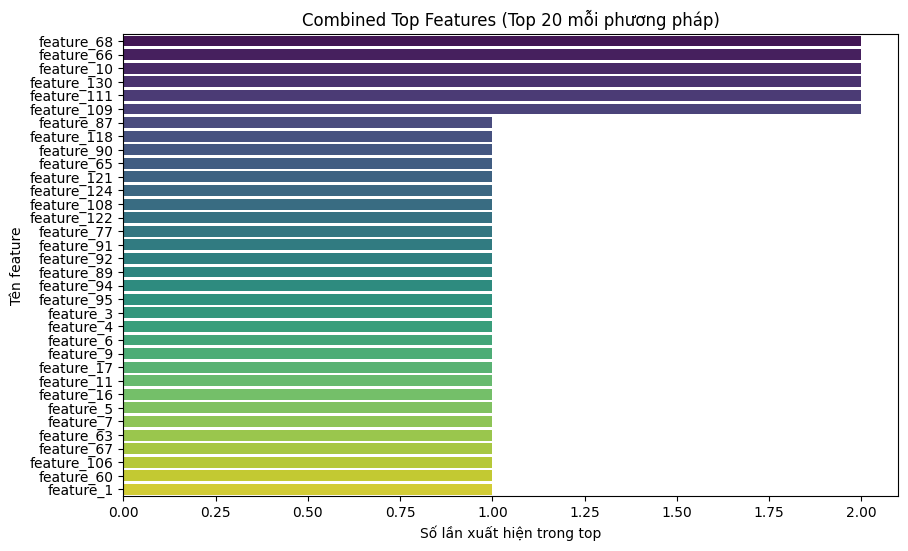


=== Phase phase3 completed ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363 entries, 0 to 5362
Columns: 199 entries, user_id to label_encoded
dtypes: float64(186), int64(9), object(4)
memory usage: 8.1+ MB
None
Batch 32, LR 0.0005, Mean Accuracy: 0.7078
Batch 32, LR 0.001, Mean Accuracy: 0.6927
Batch 64, LR 0.0005, Mean Accuracy: 0.6912
Batch 64, LR 0.001, Mean Accuracy: 0.6942
Best params: {'batch_size': 32, 'learning_rate': 0.0005}, Best Accuracy: 0.7078
Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6292 - loss: 0.9521 - val_accuracy: 0.6673 - val_loss: 0.7412 - learning_rate: 5.0000e-04
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6985 - loss: 0.7510 - val_accuracy: 0.6095 - val_loss: 0.7301 - learning_rate: 5.0000e-04
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6884 - loss: 0.7509 - val_accuracy: 0.6794 - val_loss: 0.6891 - learning_rate: 5.0000e-04
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - a

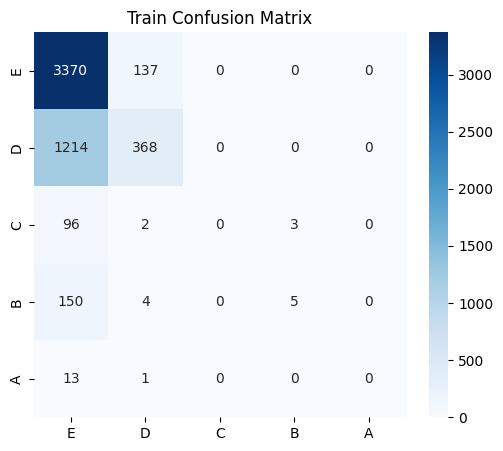

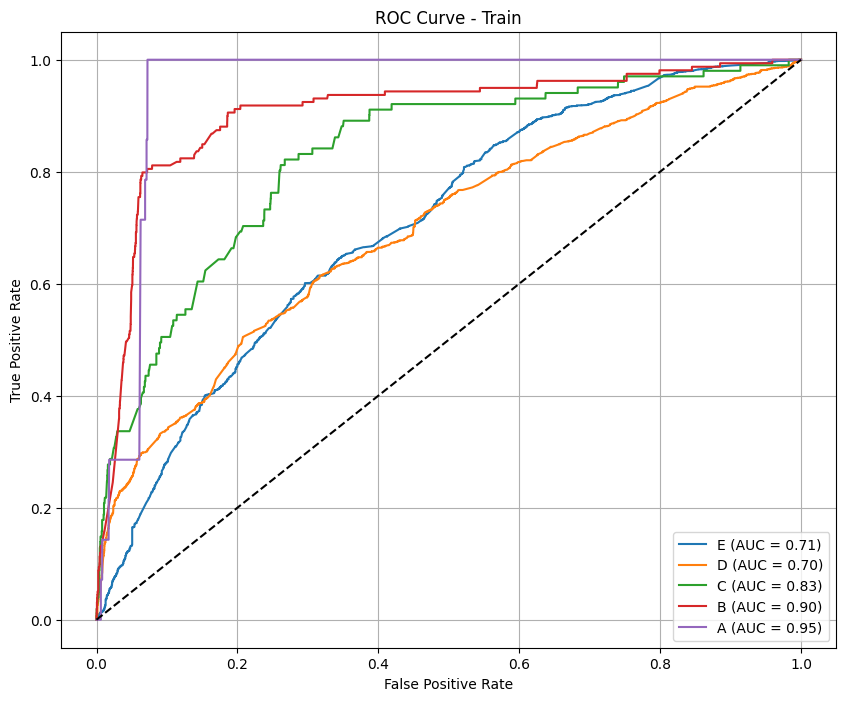


[Test Evaluation]
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

--- Test Metrics ---
F1 (per class): [0.7880597  0.31055901 0.         0.         0.        ]
Precision: [0.88       0.21097046 0.         0.         0.        ]
Recall: [0.71351351 0.58823529 0.         0.         0.        ]
Accuracy: 0.6492
ROC AUC (OvR): 0.4081
              precision    recall  f1-score   support

           E       0.88      0.71      0.79       555
           D       0.21      0.59      0.31        85
           C       0.00      0.00      0.00        18
           B       0.00      0.00      0.00        18
           A       0.00      0.00      0.00        11

    accuracy                           0.65       687
   macro avg       0.22      0.26      0.22       687
weighted avg       0.74      0.65      0.68       687



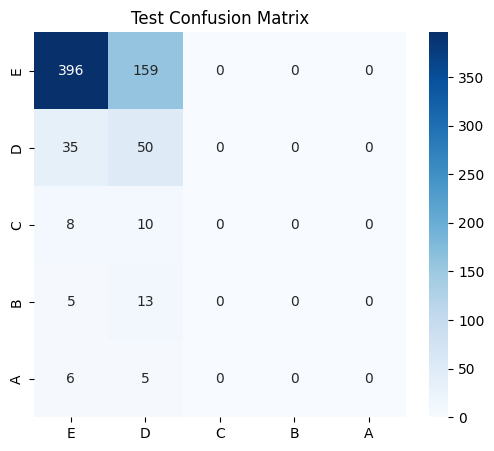

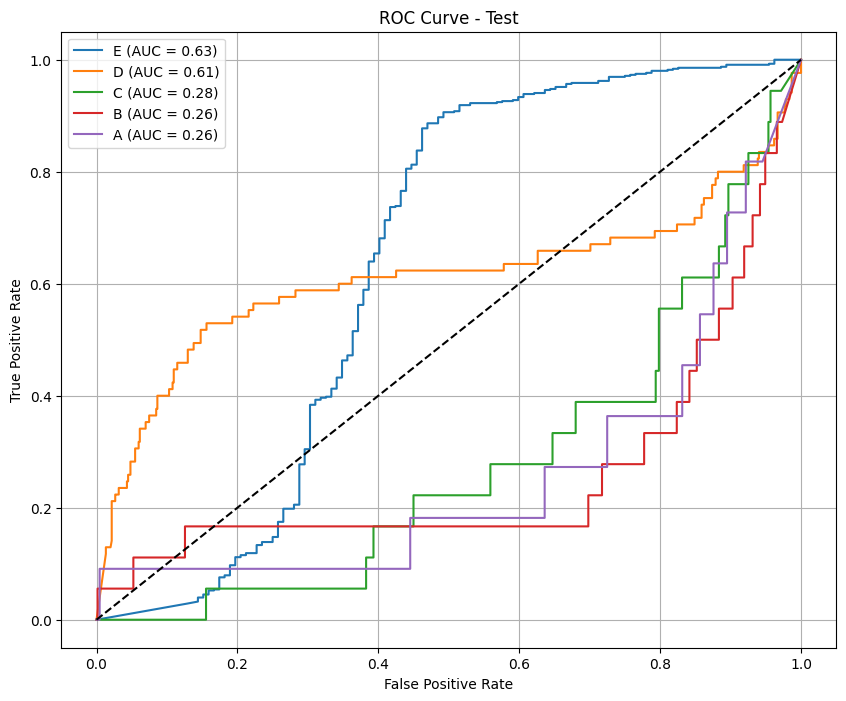


[Feature Importance with Permutation]
feature_15: Mean importance 0.0237
feature_87: Mean importance 0.0160
feature_90: Mean importance 0.0146
feature_66: Mean importance 0.0119
feature_68: Mean importance 0.0102
feature_75: Mean importance 0.0095
feature_9: Mean importance 0.0090
feature_20: Mean importance 0.0086
feature_65: Mean importance 0.0070
feature_84: Mean importance 0.0068

[Feature Importance with Lasso]
feature_9: Lasso weight 0.1732
feature_11: Lasso weight -0.1567
feature_19: Lasso weight -0.1360
feature_10: Lasso weight -0.1204
feature_16: Lasso weight 0.1125
feature_4: Lasso weight 0.0835
feature_17: Lasso weight -0.0752
feature_20: Lasso weight 0.0689
feature_152: Lasso weight 0.0601
feature_1: Lasso weight 0.0540

[Combined Feature Importance]

=== Combined Top Features ===
feature_173: xuất hiện 2 lần
feature_152: xuất hiện 2 lần
feature_9: xuất hiện 2 lần
feature_10: xuất hiện 2 lần
feature_170: xuất hiện 2 lần
feature_11: xuất hiện 2 lần
feature_63: xuất hiện 2 l

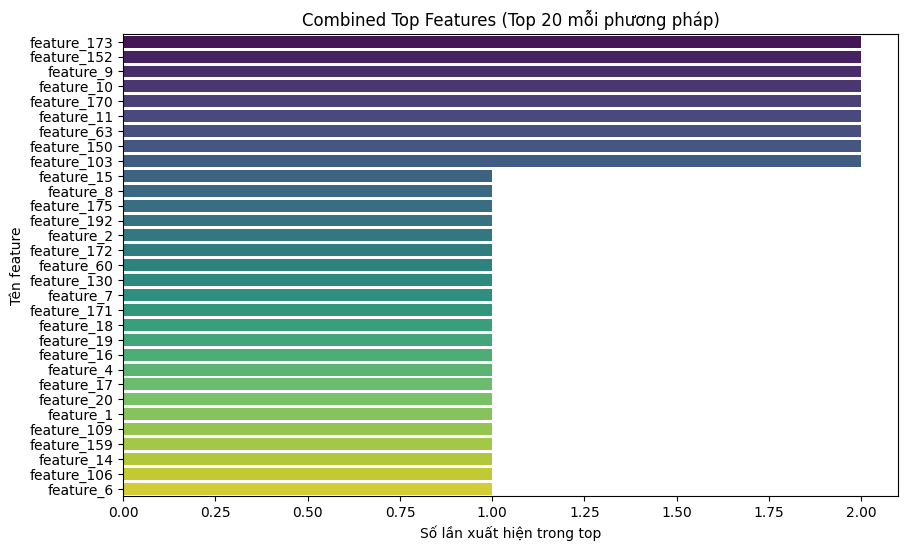


=== Phase phase4 completed ===


In [8]:
for phase in ["phase1", "phase2", "phase3", "phase4"]:
    process_phase(phase)